In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from utilities import tile_raster_images
from PIL import Image
%matplotlib inline

Defining a data point

In [2]:
v=tf.constant([1,0,1,0,1],shape=(5,1),dtype='float')

#### Initializing parameters

Local Joint Probablity is given in terms of energy (exp of negative energy of pairwise random variables) defined by:- <br>
Energy, E= -av-vWh-bh <br>
But Local conditional probablity can be given by sigmoid of an expression containing these parameters

In [3]:
W=tf.Variable(np.random.normal(size=(5,2),scale=0.01,loc=0.0),dtype='float',name='weights')
a=tf.Variable(np.random.normal(size=(5,1),scale=0.01,loc=0.0),dtype='float',name='visible_bias')
b=tf.Variable(np.random.normal(size=(2,1),scale=0.01,loc=0.0),dtype='float',name='hidden_bias')

Functions defining each forward and backward Pass.

In [4]:
def forward_pass(v0,verbose=True):
    if verbose:
        print('Calculating Probablity of hidden layer given visible layer...\n')
        
    prob=tf.nn.sigmoid(tf.reshape(tf.matmul(tf.transpose(v0),W),(2,1))+b)
    state=tf.nn.relu(tf.sign(prob-tf.random.uniform(prob.shape)))
    
    if verbose: 
        print('P(h=1/v): ',prob.numpy()[0])
        print('Hidden state:',state.numpy()[0])
    return state

def backward_pass(h0,verbose=True):
    if verbose:
        print('Calculating Probablity of vissible layer given hidden layer...\n')
    
    prob=tf.nn.sigmoid(tf.matmul(W,h0)+a)
    state=tf.nn.relu(tf.sign(prob-tf.random.uniform(prob.shape)))
    
    if verbose:
        print('P(v=1/h): ',prob.numpy()[0])
        print('Visible state:', state.numpy()[0])
    return state

#### Training Process

Due to the double expectation of gradient of energy over h and v, which is hard to commpute, we use Contrastive Gradient to replace expectation terms by point estimates using Gibbs sampling. Gibbs sampling is used obtain samples from a given distribution based upon conditional dependence.

In [5]:
def cont_div(v,W0,a0,b0,k=1,verbose=False,lr=0.1):
    v0=v
    h0=forward_pass(v0,verbose=verbose)
    alpha=lr
    
    for i in range(0,k):
        if i==0:
            v_tilda=backward_pass(h0,verbose=verbose)
        else:
            v_tilda=backward_pass(h_tilda,verbose=verbose)
        h_tilda=forward_pass(v_tilda,verbose=verbose)
        
    del_W=tf.matmul(v0,tf.transpose(h0))-tf.matmul(v_tilda,tf.transpose(h_tilda))
    W=W0+alpha*del_W
    a=a0+alpha*(v0-v_tilda)
    b=b0+alpha*(h0-h_tilda)
    
    return W,a,b

Testing functions

In [6]:
cont_div(v,W,a,b)

(<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
 array([[ 0.01311282, -0.0792423 ],
        [-0.09184723, -0.09699762],
        [-0.00380964, -0.09251657],
        [-0.10728257, -0.10372005],
        [-0.00520692, -0.08616544]], dtype=float32)>,
 <tf.Tensor: shape=(5, 1), dtype=float32, numpy=
 array([[-0.00050048],
        [-0.08643782],
        [-0.00359661],
        [-0.11834162],
        [-0.00991144]], dtype=float32)>,
 <tf.Tensor: shape=(2, 1), dtype=float32, numpy=
 array([[-0.01100094],
        [-0.10320098]], dtype=float32)>)

For k=10(iterations), taking 10 samples from the distribution.

In [7]:
cont_div(v,W,a,b,k=10)

(<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
 array([[ 0.01311282,  0.12075771],
        [ 0.00815277,  0.00300238],
        [-0.00380964,  0.00748343],
        [-0.00728257, -0.00372005],
        [-0.00520692,  0.11383456]], dtype=float32)>,
 <tf.Tensor: shape=(5, 1), dtype=float32, numpy=
 array([[ 0.09949952],
        [ 0.01356218],
        [-0.00359661],
        [-0.01834162],
        [ 0.09008856]], dtype=float32)>,
 <tf.Tensor: shape=(2, 1), dtype=float32, numpy=
 array([[-0.01100094],
        [-0.00320098]], dtype=float32)>)

#### Creating an instance of model

In [8]:
class RBM():
    
    def __init__(self,v,h):
        self.W=tf.Variable(np.random.normal(size=(v,h),scale=0.01,loc=0.0)\
                           ,dtype='float64',name='weights')
        self.a=tf.Variable(np.random.normal(size=(1,v),scale=0.01,loc=0.0)\
                           ,dtype='float64',name='visible_bias')
        self.b=tf.Variable(np.random.normal(size=(1,h),scale=0.01,loc=0.0)\
                           ,dtype='float64',name='hidden_bias')
        self.var=(self.W,self.a,self.b)
        self.lr=0.01
        self.errors=[]
        
    def forward_pass(self,v0,var,verbose=True):
        if verbose:
            print('Calculating Probablity of hidden layer given visible layer...\n')
        prob=tf.nn.sigmoid(tf.matmul(v0,var[0])+var[2])
        state=tf.nn.relu(tf.sign(prob-tf.random.uniform(prob.shape,dtype='float64')))
    
        if verbose: 
            print('P(h=1/v): ',prob.numpy()[0])
            print('Hidden state:',state.numpy()[0])
        return state

    def backward_pass(self,h0,var,verbose=True):
        if verbose:
            print('Calculating Probablity of vissible layer given hidden layer...\n')
    
        prob=tf.nn.sigmoid(tf.matmul(h0,tf.transpose(var[0]))+var[1])
        state=tf.nn.relu(tf.sign(prob-tf.random.uniform(prob.shape,dtype='float64')))
    
        if verbose:
            print('P(v=1/h): ',prob.numpy()[0])
            print('Visible state:', state.numpy()[0])
        return state

    def cont_div(self,v,var,k=1,verbose=False):
        v0=v
        h0=self.forward_pass(v0,var,verbose=verbose)
        alpha=self.lr
    
        for i in range(0,k):
            if i==0:
                v_tilda=self.backward_pass(h0,var,verbose=verbose)
            else:
                v_tilda=self.backward_pass(h_tilda,var,verbose=verbose)
            h_tilda=self.forward_pass(v_tilda,var,verbose=verbose)
            
        self.errors.append(self.error(v0,v_tilda))
        del_W=tf.matmul(tf.transpose(v0),h0)-tf.matmul(tf.transpose(v_tilda),h_tilda)
        self.var[0].assign(var[0]+alpha*del_W)
        self.var[1].assign(var[1]+alpha*tf.reduce_sum(v0-v_tilda,axis=0))
        self.var[2].assign(var[2]+alpha*tf.reduce_sum(h0-h_tilda,axis=0))
        return (W,a,b)
    
    def get_batch(self,data,batch_size):
        batch_len=len(data)//batch_size
        array=np.zeros((batch_len,batch_size,data.shape[1]))
        for i in range(0,batch_len):
            array[i,:,:]=data[i:i+batch_size]     
        return array
    
    def error(self,y,y_hat):
        return tf.reduce_mean(tf.square(y-y_hat))
    
    def train(self,data,batch_size,epoch=1):
        batches=self.get_batch(data,batch_size)
        for i in range(0,epoch):
            print(f"Epoch===> {i+1}")
            for batch in batches:
                self.cont_div(batch,self.var)
            print("Mean reconstruction error: %.4f "%(tf.reduce_mean(self.errors).numpy()))
            
    def encode(self, x_data):
        energy=tf.matmul(x_data, self.W)+self.b
        state=tf.round(tf.nn.sigmoid(energy))
        return state
        
    def decode(self, val):
        energy=tf.matmul(val, tf.transpose(self.W))+self.a
        state=tf.nn.sigmoid(energy)
        return state

#### Working with the created model

In [9]:
data=keras.datasets.mnist
(train_x, train_y), (test_x, test_y)=data.load_data()

flatten = keras.layers.Flatten(dtype='float')
train_x = flatten(train_x/255)
train_y = flatten(train_x/255)

In [10]:
model=RBM(train_x.shape[1],50)
W1=model.W
model.train(train_x,1,epoch=5)

Epoch===> 1
Mean reconstruction error: 0.0797 
Epoch===> 2
Mean reconstruction error: 0.0744 
Epoch===> 3
Mean reconstruction error: 0.0718 
Epoch===> 4
Mean reconstruction error: 0.0703 
Epoch===> 5
Mean reconstruction error: 0.0692 


### Visualization of error

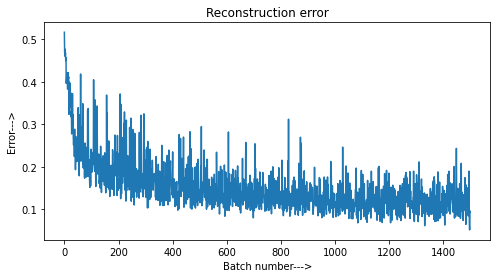

In [11]:
plt.figure(figsize=(8,4))
plt.plot(model.errors[0:1500])
plt.title('Reconstruction error')
plt.xlabel('Batch number--->')
plt.ylabel('Error--->')
plt.show()

### Testing model

Here, the tiled figures correspond to each hidden node. How each node encodes the features of the input image.

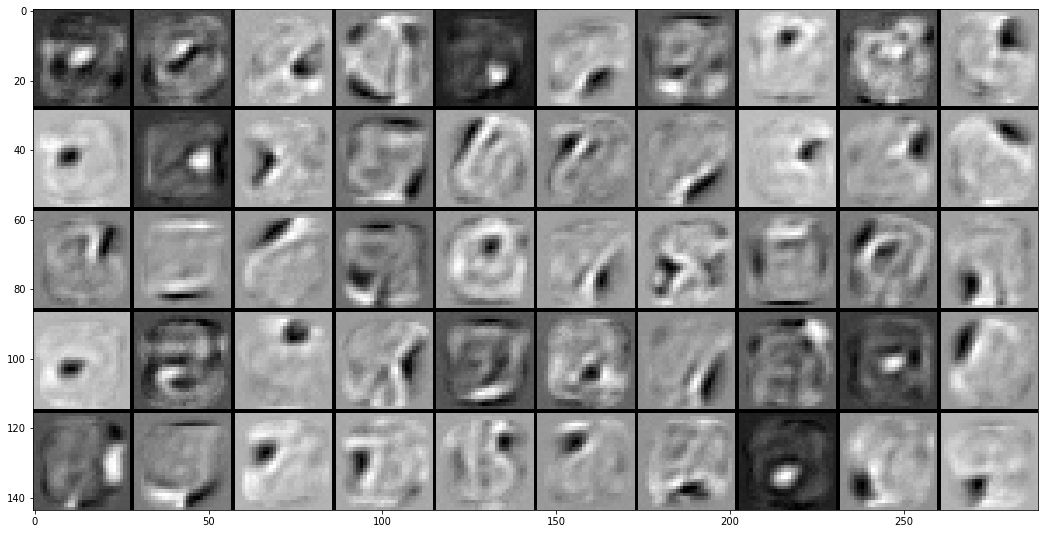

In [12]:
tiles=tile_raster_images(X=model.W.numpy().T,img_shape=(28,28),tile_shape=(5,10),tile_spacing=(1,1))
plt.figure(figsize=(18,18))
plt.imshow(tiles)
plt.set_cmap('gray')
plt.show()

#### Testing with a sample image

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0

  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0

100     5    0     5    0     0      1      0 --:--:--  0:00:03 --:--:--     1
100     5    0     5    0     0      1      0 --:--:--  0:00:03 --:--:--     0

  0     0    0     0    0     0      0      0 --:--:--  0:00:03 --:--:--     0
 48 24383   48 11676    0     0   2335      0  0:00:10  0:00:05  0:00:05  7626
100 24383  100 24383    0     0   4876      0  0:00:05  0:00:05 --:--:-- 13338


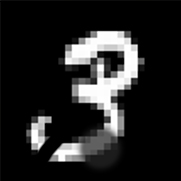

In [13]:
!curl -L "https://ibm.box.com/shared/static/vvm1b63uvuxq88vbw9znpwu5ol380mco.jpg" -o "./destructed3.jpg"
img = Image.open('./destructed3.jpg')
img

This shows how the input image is reconstructed by the RBM model

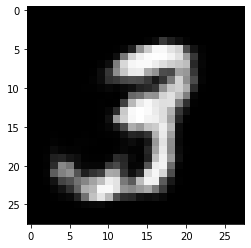

In [14]:
sample=np.array(img.convert('I').resize((28,28)),dtype='float64').ravel().reshape((1,-1))/255.0

h_sample=model.encode(sample)
v_sample=model.decode(h_sample)
plt.imshow(v_sample.numpy().reshape((28,28)))
plt.show()